In [2]:
import re
import os
import glob
from datetime import datetime

# Root of regex experiment results
main_dir = "results"

# Get all subdirectories in the main directory
sub_dirs = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

# Parse the date from the directory names and find the most recent one
date_format = '%d-%m-%Y'
most_recent_sub_dir = max(sub_dirs, key=lambda x: datetime.strptime(os.path.basename(x), date_format))

# Use the most recent sub-directory as the base directory for globbing
base_dir = most_recent_sub_dir

# Load all txt files
all_files = glob.glob(os.path.join(base_dir, '*.txt'))

# Filter for buffer only
buffer_files = [f for f in all_files if 'buffer' in os.path.basename(f) and 'group' not in os.path.basename(f)]

# Filter for group only
group_files = [f for f in all_files if 'group' in os.path.basename(f) and 'buffer' not in os.path.basename(f)]

# Filter for combination of buffer and group
combination_files = [f for f in all_files if 'buffer' in os.path.basename(f) and 'group' in os.path.basename(f)]

# Filter for the single 'whole' file
default_files = [f for f in all_files if 'whole' in os.path.basename(f)]

# Load all csv files
all_csv_files = glob.glob(os.path.join(base_dir, '*.csv'))

# Filter for 'cpu' results file
cpu_files = [f for f in all_csv_files if 'cpu-results' in os.path.basename(f)]

In [3]:
# Define fn for content parsing
def parse_content(file_path: str):
    # Define patterns to extract necessary data
    patterns = {
        "INPUT_ITERATIONS": r"INPUT ITERATIONS:\s*(\d+)",
        "BUFFER_LENGTH": r"BUFFER LENGTH:\s*(\d+)",
        "GROUP/BATCH SIZE": r"GROUP/BATCH SIZE:\s*(\d+)",
        "REGEX PERFORMANCE (Gb/s)": r"REGEX PERFORMANCE \(Gb/s\):\s*([\d\.]+)",
        "MAX REGEX PERFORMANCE (Gb/s)": r"MAX REGEX PERFORMANCE \(Gb/s\):\s*([\d\.]+)",
        "TOTAL DURATION": r"TOTAL DURATION \(secs\):\s*([\d\.]+)",
        "MATCH TO BYTE RATIO": r"MATCH TO BYTE RATIO:\s*([\d\.]+)"
    }
    pattern_canonical_names = {
        "INPUT_ITERATIONS": "iters",
        "BUFFER_LENGTH": "buffer_len",
        "GROUP/BATCH SIZE": "group_len",
        "REGEX PERFORMANCE (Gb/s)": "regex_perf",
        "MAX REGEX PERFORMANCE (Gb/s)": "regex_perf_max",
        "TOTAL DURATION": "duration",
        "MATCH TO BYTE RATIO": "regex_matches_per_byte"
    }
    results = {}
    with open(file_path, 'r') as file:
        log_data = file.read()
        # Extract data using the defined patterns
    for key, pattern in patterns.items():
        match = re.search(pattern, log_data, re.MULTILINE)
        if match:
            results[pattern_canonical_names[key]] = match.group(1)
        else:
            results[pattern_canonical_names[key]] = 'Not found'
    return results

In [4]:
import csv

# Dictionaries to store the results
buffer_results = {}
group_results = {}
combination_results = {}
default_results = {}
cpu_results = {}

# Define the regex pattern to find numbers after specific keywords
buffer_pattern = re.compile(r'buffer-(\d+)')
group_pattern = re.compile(r'group-(\d+)')
regex_idx_pattern = re.compile(r'regex-(\d+)')
# Define the regex pattern to find buffer and group numbers in combined filenames
combination_pattern = re.compile(r'buffer-(\d+)-group-(\d+)')

# Parse buffer values
for filename in buffer_files:
    match = buffer_pattern.search(filename)
    reg_idx_match = regex_idx_pattern.search(filename)
    if match and reg_idx_match:
        value = int(match.group(1))  # Convert found string to integer
        reg_idx = int(reg_idx_match.group(1))
        if reg_idx not in buffer_results:
            buffer_results[reg_idx] = {}
        buffer_results[reg_idx][value] = parse_content(filename)

# Parse group values
for filename in group_files:
    match = group_pattern.search(filename)
    reg_idx_match = regex_idx_pattern.search(filename)
    if match and reg_idx_match:
        value = int(match.group(1))  # Convert found string to integer
        reg_idx = int(reg_idx_match.group(1))
        if reg_idx not in group_results:
            group_results[reg_idx] = {}
        group_results[reg_idx][value] = parse_content(filename)

# Parse and format buffer and group values
for filename in combination_files:
    match = combination_pattern.search(os.path.basename(filename))
    reg_idx_match = regex_idx_pattern.search(filename)
    if match and reg_idx_match:
        buffer_value = match.group(1)
        group_value = match.group(2)
        # Format the string as 'buffer_value-group_value'
        formatted_string = f"{buffer_value}-{group_value}"
        reg_idx = int(reg_idx_match.group(1))
        if reg_idx not in combination_results:
            combination_results[reg_idx] = {}
        combination_results[reg_idx][formatted_string] = parse_content(filename)

# Parse and format default settings
for filename in default_files:
    reg_idx_match = regex_idx_pattern.search(filename)
    if reg_idx_match:
        reg_idx = int(reg_idx_match.group(1))
        if reg_idx not in default_results:
            default_results[reg_idx] = {}
        default_results[reg_idx] = parse_content(filename)

In [38]:
# Function to save the figure to the desired directory
from pathlib import Path
def save_figure(fig, filename, target_dir: Path=Path("../../tex/figures/za-evaluation")):
    # Ensure target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # Construct the full path
    file_path = os.path.join(target_dir, filename)
    
    # Save the figure
    fig.savefig(file_path)
    print(f"Figure saved to {file_path}")

Figure saved to ../../tex/figures/za-evaluation/regex_buffer_size_performance.png


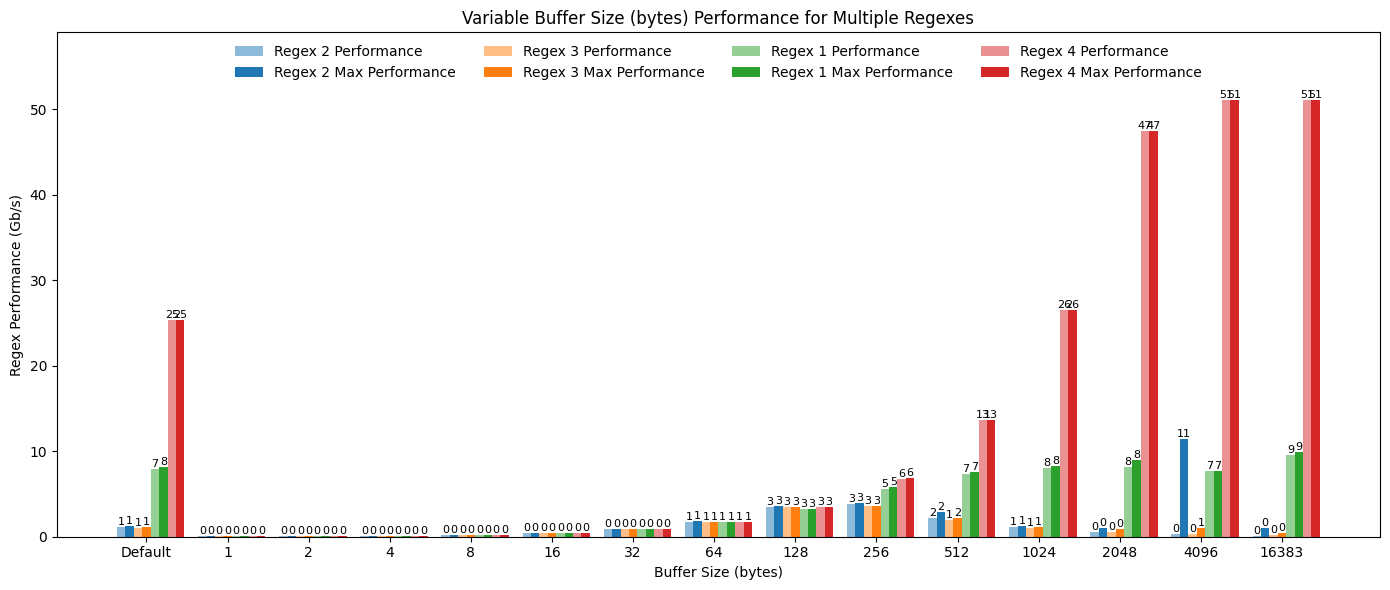

In [43]:
# Buffer size visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Regex ids
regex_ids = list(default_results.keys())  # Get regex ids

# Collect buffer sizes and include 'Default'
buffer_sizes = sorted(list(buffer_results[regex_ids[0]].keys()))
buffer_sizes.insert(0, 'Default')  # Using 'Default' as a label for the default settings

# Initialize data structures
all_regular_perf_values = {reg_idx: [] for reg_idx in regex_ids}
all_max_perf_values = {reg_idx: [] for reg_idx in regex_ids}

for reg_idx in regex_ids:
    # Collect data for each regex
    regular_perf_values = [float(buffer_results[reg_idx][b]['regex_perf']) for b in buffer_sizes[1:]]
    max_perf_values = [float(buffer_results[reg_idx][b]['regex_perf_max']) for b in buffer_sizes[1:]]
    
    # Insert the default results data at the beginning
    regular_perf_values.insert(0, float(default_results[reg_idx]['regex_perf']))
    max_perf_values.insert(0, float(default_results[reg_idx]['regex_perf_max']))

    all_regular_perf_values[reg_idx] = regular_perf_values
    all_max_perf_values[reg_idx] = max_perf_values

# Setup for side-by-side bars with gaps
x = np.arange(len(buffer_sizes))  # the label locations
total_width = 0.83  # total width for all bars at one x location
num_bars = len(regex_ids) * 2  # two bars for each regex (regular and max performance)
width = total_width / num_bars  # the width of each bar
gap = width * 1.66  # Define a gap width

fig, ax = plt.subplots(figsize=(14, 6))

for i, reg_idx in enumerate(regex_ids):
    color = plt.cm.tab10(i % 10)  # Get a color from the colormap
    lighter_color = mcolors.to_rgba(color, alpha=0.5)  # Softer version of the color

    # Calculate the position for the bars in the group
    # Group each set of bars by shifting their x position within the group
    x_pos = x + i * 2 * width

    bars1 = ax.bar(x_pos, all_regular_perf_values[reg_idx], width, label=f'Regex {reg_idx} Performance', color=lighter_color)
    bars2 = ax.bar(x_pos + width, all_max_perf_values[reg_idx], width, label=f'Regex {reg_idx} Max Performance', color=color)

    # Adding data labels on bars
    for bar in bars1 + bars2:  # Iterate over all bars
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{int(yval)}", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Buffer Size (bytes)')
ax.set_ylabel('Regex Performance (Gb/s)')
ax.set_title("Variable Buffer Size (bytes) Performance for Multiple Regexes")

# X ticks and labels
ax.set_xticks(x + total_width / 2 - width)  # Adjust x-ticks to be in the middle of the grouped bars
ax.set_xticklabels(buffer_sizes)

# Adding a legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper center', frameon=False, ncol=4)

# Increase limits to accomodate the legend
_, ymax = ax.get_ylim()
ax.set_ylim([0, ymax + (ymax * .1)])

# Tighten the plot
plt.tight_layout()

# Save the figure
save_figure(fig, "regex_buffer_size_performance.png")

# Show the plot
plt.show()

In [44]:
# # This can also be calculated as (TOTAL REGEX BUFFERS / TOTAL REGEX MATCHES) * AVERAGE REGEX BUFFER LENGTH
# # Pattern Density visualization
# import matplotlib.colors as mcolors
# import matplotlib.pyplot as plt
# import numpy as np

# # Regex ids and buffer sizes from your original code
# regex_ids = list(default_results.keys())  # Get regex ids
# buffer_sizes = sorted(list(buffer_results[regex_ids[0]].keys()))
# buffer_sizes.insert(0, 'Default')  # Using 'Default' as a label for the default settings

# # Initialize data structures
# all_regular_perf_values = {reg_idx: [] for reg_idx in regex_ids}

# for reg_idx in regex_ids:
#     # Collect data for each regex
#     regular_match_per_byte_values = [float(buffer_results[reg_idx][b]['regex_matches_per_byte']) for b in buffer_sizes[1:]]
#     regular_match_per_byte_values.insert(0, float(default_results[reg_idx]['regex_matches_per_byte']))

#     all_regular_perf_values[reg_idx] = regular_match_per_byte_values

# # Setup for side-by-side bars with gaps
# x = np.arange(len(buffer_sizes))  # the label locations
# total_width = 0.83  # total width for all bars at one x location
# num_bars = len(regex_ids)  # number of bars for each regex (one per regex)
# width = total_width / num_bars  # the width of each bar

# fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# for i, reg_idx in enumerate(regex_ids):
#     color = plt.cm.tab10(i % 10)  # Get a color from the colormap
#     lighter_color = mcolors.to_rgba(color, alpha=0.5)  # Softer version of the color

#     # Calculate the position for the bars in the group
#     x_pos = x + (i - (num_bars / 2)) * width + (width / 2)

#     bars1 = ax.bar(x_pos, all_regular_perf_values[reg_idx], width, label=f'Regex {reg_idx}', color=lighter_color)

#     # Adding data labels on bars
#     for bar in bars1:  # Iterate over all bars
#         yval = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.3f}", ha='center', va='bottom', fontsize=7, rotation=90)

# # Add labels and title
# ax.set_xlabel('Buffer Size (bytes)')
# ax.set_ylabel('Regex Performance (Matches per Byte Ratio)')  # Updated Y axis label
# ax.set_title("Pattern Density (matches per bytes of input) for Multiple Regexes")

# # X ticks and labels
# ax.set_xticks(x)  # Adjust x-ticks to be in the middle of the grouped bars
# ax.set_xticklabels(buffer_sizes)

# # Adding a legend
# handles, labels = ax.get_legend_handles_labels()
# unique_labels = dict(zip(labels, handles))
# ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', frameon=False, bbox_to_anchor=(1, 1))

# # Show the plot
# plt.tight_layout()
# plt.show()

Figure saved to ../../tex/figures/za-evaluation/regex_group_size_performance.png


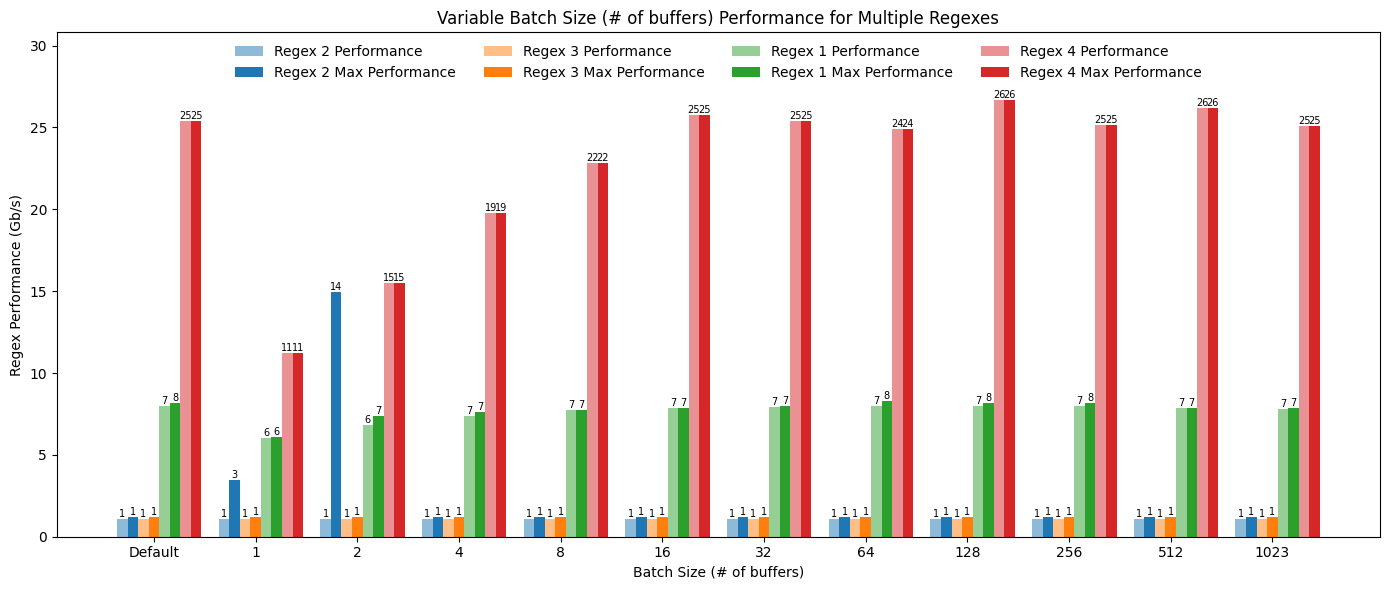

In [45]:
# Group size visualization
import matplotlib.pyplot as plt
import numpy as np

# Regex ids
regex_ids = list(default_results.keys())  # Get regex ids

# Collect group sizes and include 'Default'
group_sizes = sorted(list(group_results[regex_ids[0]].keys()))
group_sizes.insert(0, 'Default')  # Using 'Default' as a label for the default settings

# Initialize data structures
all_regular_perf_values = {reg_idx: [] for reg_idx in regex_ids}
all_max_perf_values = {reg_idx: [] for reg_idx in regex_ids}

for reg_idx in regex_ids:
    # Collect data for each regex
    regular_perf_values = [float(group_results[reg_idx][b]['regex_perf']) for b in group_sizes[1:]]
    max_perf_values = [float(group_results[reg_idx][b]['regex_perf_max']) for b in group_sizes[1:]]
    
    # Insert the default results data at the beginning
    regular_perf_values.insert(0, float(default_results[reg_idx]['regex_perf']))
    max_perf_values.insert(0, float(default_results[reg_idx]['regex_perf_max']))

    all_regular_perf_values[reg_idx] = regular_perf_values
    all_max_perf_values[reg_idx] = max_perf_values

# Setup for side-by-side bars with gaps
x = np.arange(len(group_sizes))  # the label locations
total_width = 0.83  # total width for all bars at one x location
num_bars = len(regex_ids) * 2  # two bars for each regex (regular and max performance)
width = total_width / num_bars  # the width of each bar
gap = width * 1.66  # Define a gap width

fig, ax = plt.subplots(figsize=(14, 6))

for i, reg_idx in enumerate(regex_ids):
    color = plt.cm.tab10(i % 10)  # Get a color from the colormap
    lighter_color = mcolors.to_rgba(color, alpha=0.5)  # Softer version of the color

    # Calculate the position for the bars in the group
    # Group each set of bars by shifting their x position within the group
    x_pos = x + i * 2 * width

    bars1 = ax.bar(x_pos, all_regular_perf_values[reg_idx], width, label=f'Regex {reg_idx} Performance', color=lighter_color)
    bars2 = ax.bar(x_pos + width, all_max_perf_values[reg_idx], width, label=f'Regex {reg_idx} Max Performance', color=color)

    # Adding data labels on bars
    for bar in bars1 + bars2:  # Iterate over all bars
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{int(yval)}", ha='center', va='bottom', fontsize=7)

# Add labels and title
ax.set_xlabel('Batch Size (# of buffers)')
ax.set_ylabel('Regex Performance (Gb/s)')
ax.set_title("Variable Batch Size (# of buffers) Performance for Multiple Regexes")

# X ticks and labels
ax.set_xticks(x + total_width / 2 - width)  # Adjust x-ticks to be in the middle of the grouped bars
ax.set_xticklabels(group_sizes)

# Adding a legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper center', frameon=False, ncol=4)

# Increase limits to accomodate the legend
_, ymax = ax.get_ylim()
ax.set_ylim([0, ymax + (ymax * .1)])

# Tighten the plot
plt.tight_layout()

# Save the figure
save_figure(fig, "regex_group_size_performance.png")

# Show the plot
plt.show()

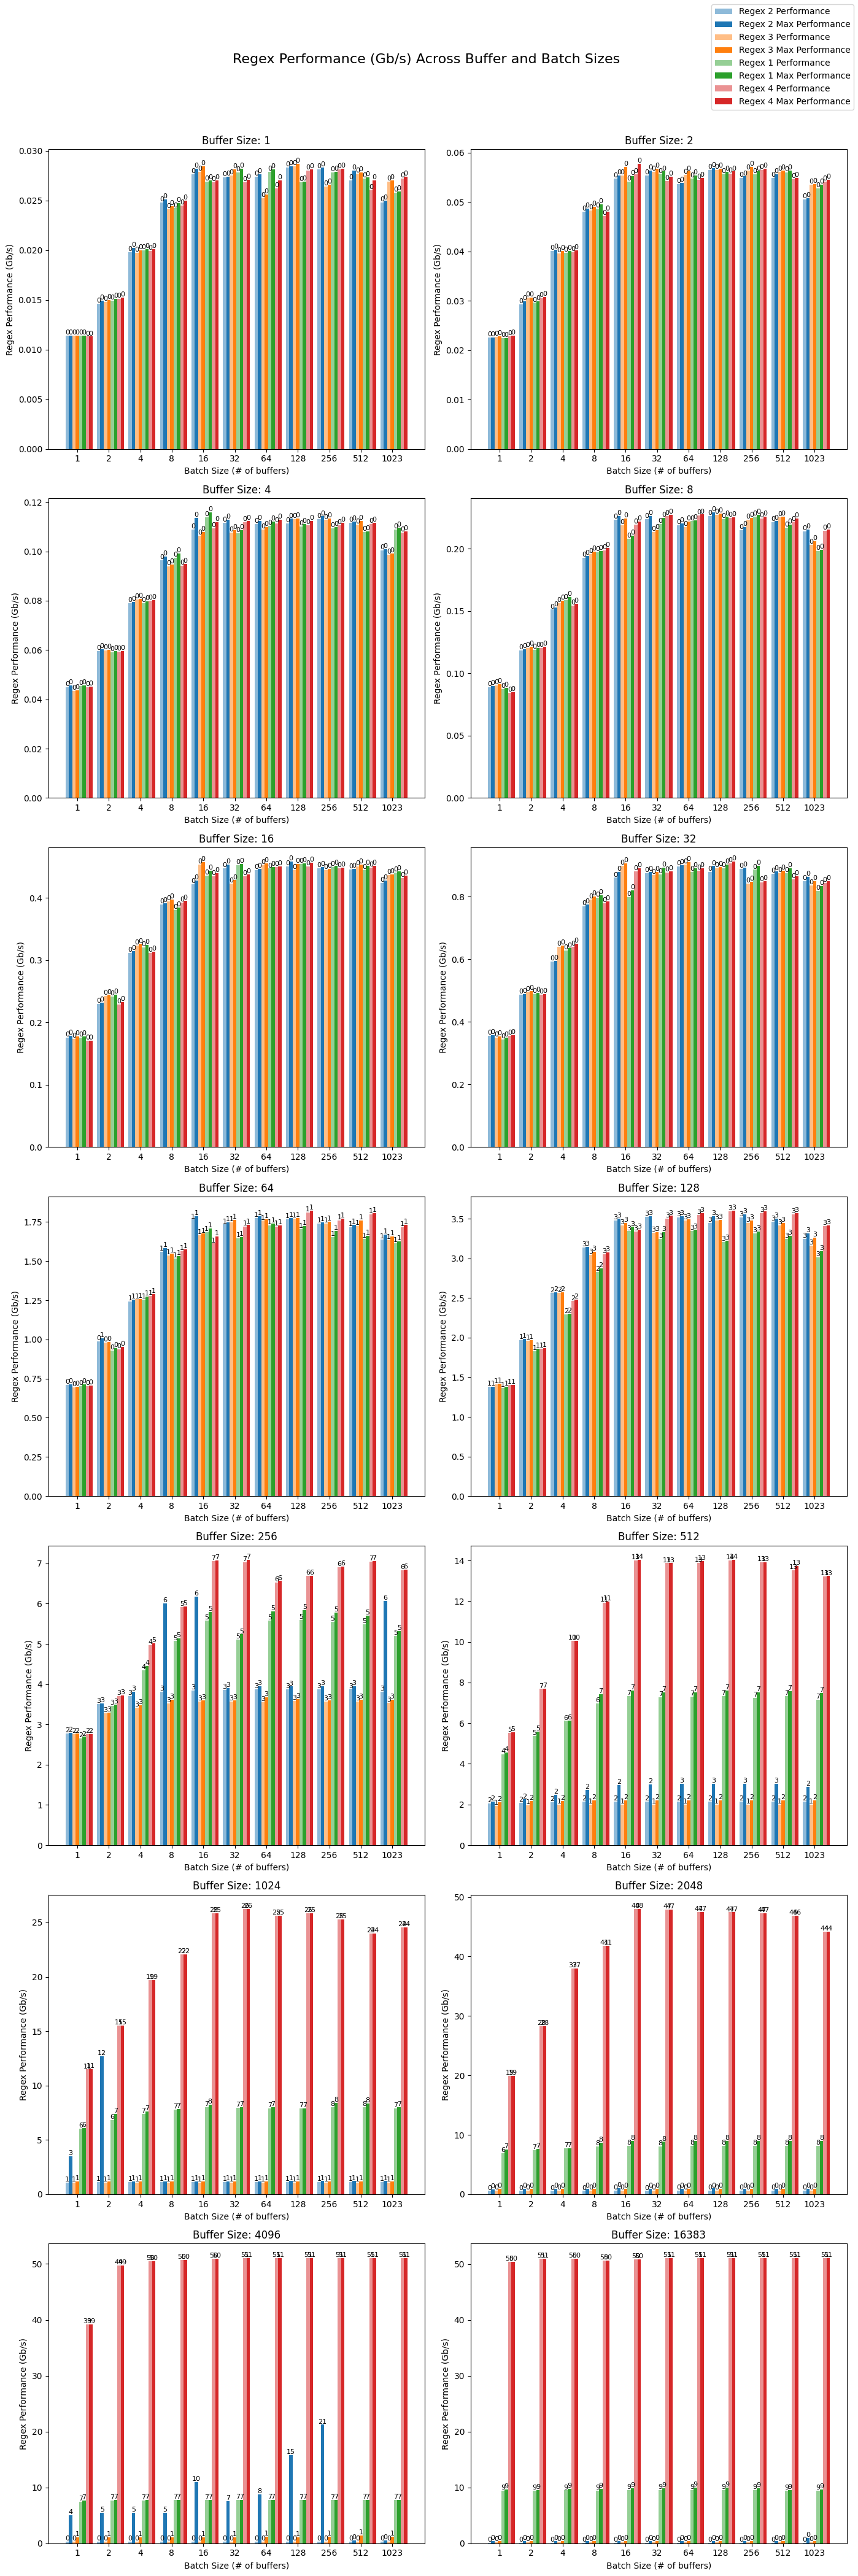

In [18]:
# Generate all possible combinations of buffer and group sizes
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Regex ids
regex_ids = list(default_results.keys())

# Get unique buffer sizes from the keys
buffer_sizes = sorted(buffer_results[regex_ids[0]].keys())

# Get unique group sizes from the keys
group_sizes = sorted(group_results[regex_ids[0]].keys())

# Set up figure and axes for the plots
fig, axes = plt.subplots(nrows=(len(buffer_sizes) + 1) // 2, ncols=2, figsize=(14, 6 * ((len(buffer_sizes) + 1) // 2)))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

# Iterate over each buffer size and create a subplot
for ax, buffer_size in zip(axes, buffer_sizes):
    # Prepare the data for this buffer size
    all_regular_perf_values = {reg_idx: [float(combination_results[reg_idx][f"{buffer_size}-{g}"]['regex_perf']) for g in group_sizes] for reg_idx in regex_ids}
    all_max_perf_values = {reg_idx: [float(combination_results[reg_idx][f"{buffer_size}-{g}"]['regex_perf_max']) for g in group_sizes] for reg_idx in regex_ids}

    x = np.arange(len(group_sizes))  # the label locations
    total_width = 0.86  # total width for all bars at one x location
    num_bars = len(regex_ids) * 2  # two bars for each regex (regular and max performance)
    width = total_width / num_bars  # the width of each bar
    gap = width * 1.5  # Define a gap width

    for i, reg_idx in enumerate(regex_ids):
        color = plt.cm.tab10(i % 10)  # Get a color from the colormap
        lighter_color = mcolors.to_rgba(color, alpha=0.5)  # Softer version of the color

        # Calculate the position for the bars in the group
        x_pos = x + i * 2 * width

        bars1 = ax.bar(x_pos, all_regular_perf_values[reg_idx], width, label=f'Regex {reg_idx} Performance', color=lighter_color)
        bars2 = ax.bar(x_pos + width, all_max_perf_values[reg_idx], width, label=f'Regex {reg_idx} Max Performance', color=color)

        # Adding data labels on bars
        for bar in bars1 + bars2:  # Iterate over all bars
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{int(yval)}", ha='center', va='bottom', fontsize=8)

    # Set title and labels for each subplot
    ax.set_title(f'Buffer Size: {buffer_size}')
    ax.set_xticks(x + total_width / 2 - width)
    ax.set_xticklabels([f'{g}' for g in group_sizes])
    ax.set_xlabel('Batch Size (# of buffers)')
    ax.set_ylabel('Regex Performance (Gb/s)')

# Set common labels and legend
fig.suptitle('Regex Performance (Gb/s) Across Buffer and Batch Sizes', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the common labels and title
plt.show()

In [19]:
# Open and parse cpu results (contains all regex info)
results = []
with open(cpu_files[0], mode='r', newline='') as cpu_file:
    reader = csv.DictReader(cpu_file)
    for row in reader:
        results.append(row)

regexes = [result["regex"] for result in results]
memory_throughput = [float(result["avg_throughput_memory"]) for result in results]
streaming_throughput = [float(result["avg_throughput_streaming"]) for result in results]

# Convert bytes per second to gigabytes per second (1 GB = 1e9 bytes)
memory_throughput = [float(result["avg_throughput_memory"]) / 1e9 for result in results]
streaming_throughput = [float(result["avg_throughput_streaming"]) / 1e9 for result in results]

# Set the positions and width for the bars
bar_width = 0.35
r1 = range(len(memory_throughput))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, memory_throughput, color='blue', width=bar_width, edgecolor='grey', label='In-Memory')
plt.bar(r2, streaming_throughput, color='green', width=bar_width, edgecolor='grey', label='Streaming')

# Add labels
plt.xlabel('Regex Patterns', fontweight='bold')
plt.ylabel('Throughput (GB/s)', fontweight='bold')
plt.title('Throughput Comparison: In-Memory vs Streaming')
plt.xticks([r + bar_width / 2 for r in range(len(memory_throughput))], regexes)
plt.legend()

# Tighten the plot
plt.tight_layout()

# Save the figure
save_figure(fig, "regex_cpu_performance.png")

# Show the plot
plt.show()

IndexError: list index out of range